Successfully loaded 'train.csv'.

--- Section 1.5: Exploratory Data Analysis ---


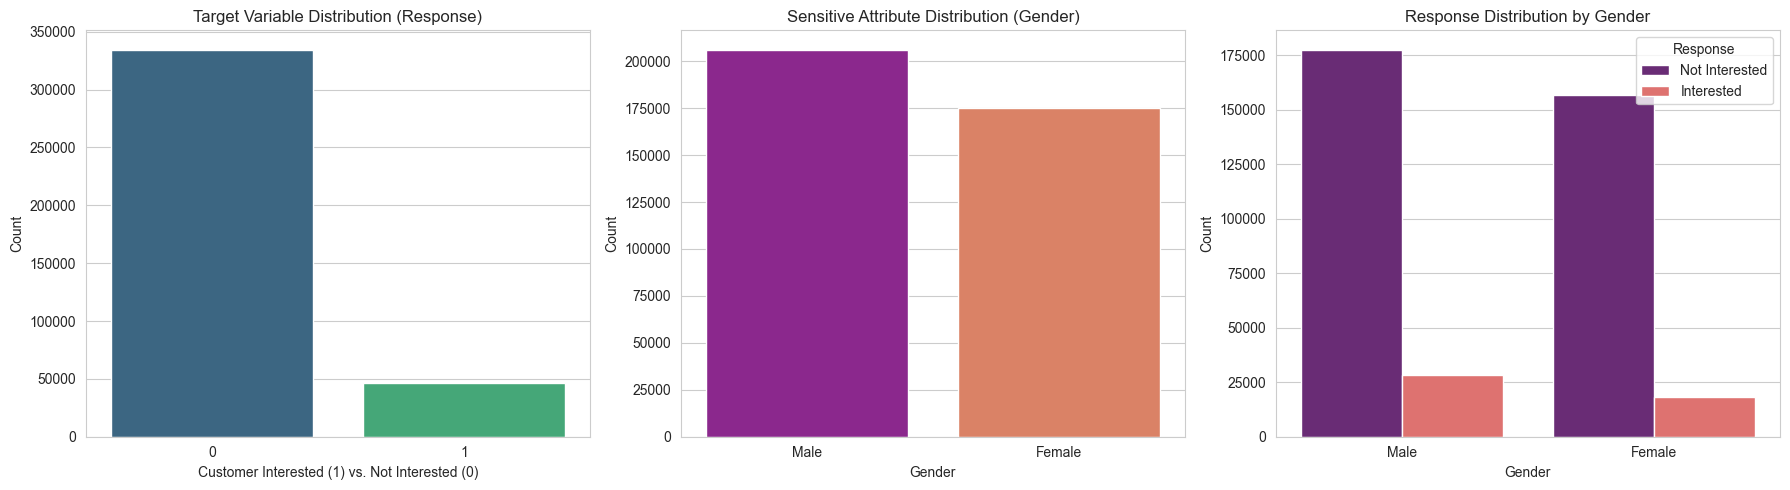


Data preprocessing and splitting complete.

Section 2: Training Baseline Model
  - Best threshold found: 0.67 (F1-score: 0.4364)

--- Visualizing Threshold Tuning for Baseline Model ---


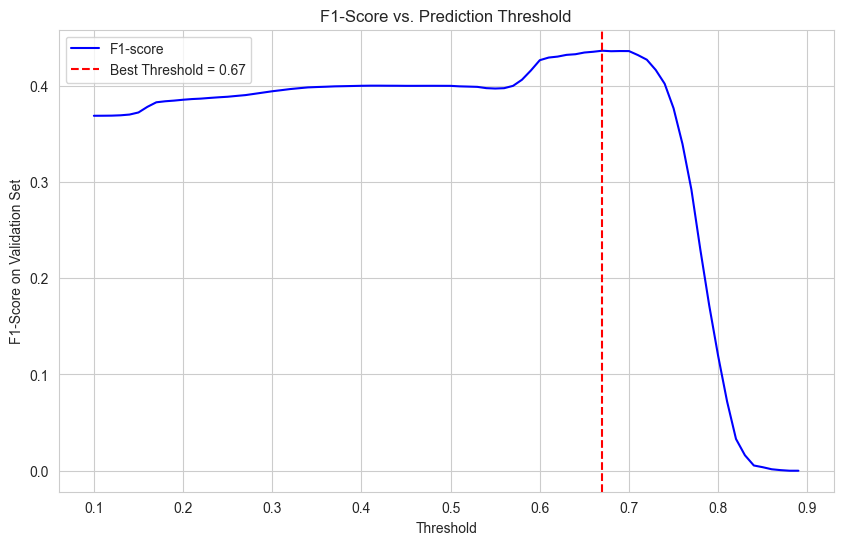


--- Evaluating: Baseline (Balanced) (Threshold: 0.67) ---

Summary for Baseline (Balanced):
- Overall Accuracy: 76.13%, Precision: 30.68%, Recall (TPR): 75.29%
- Disparate Impact (difference in positive rates): 9.97%
- Difference in Equal Opportunity (TPR): 4.62%
- Difference in Predictive Equality (FPR): 8.53%


Section 3: Applying Manual Resampling Techniques
  - Best threshold found: 0.67 (F1-score: 0.4361)

--- Evaluating: Oversampling (Threshold: 0.67) ---

Summary for Oversampling:
- Overall Accuracy: 76.13%, Precision: 30.69%, Recall (TPR): 75.32%
- Disparate Impact (difference in positive rates): 9.98%
- Difference in Equal Opportunity (TPR): 4.71%
- Difference in Predictive Equality (FPR): 8.53%


--- Visualizing the Effect of Oversampling on Training Data ---


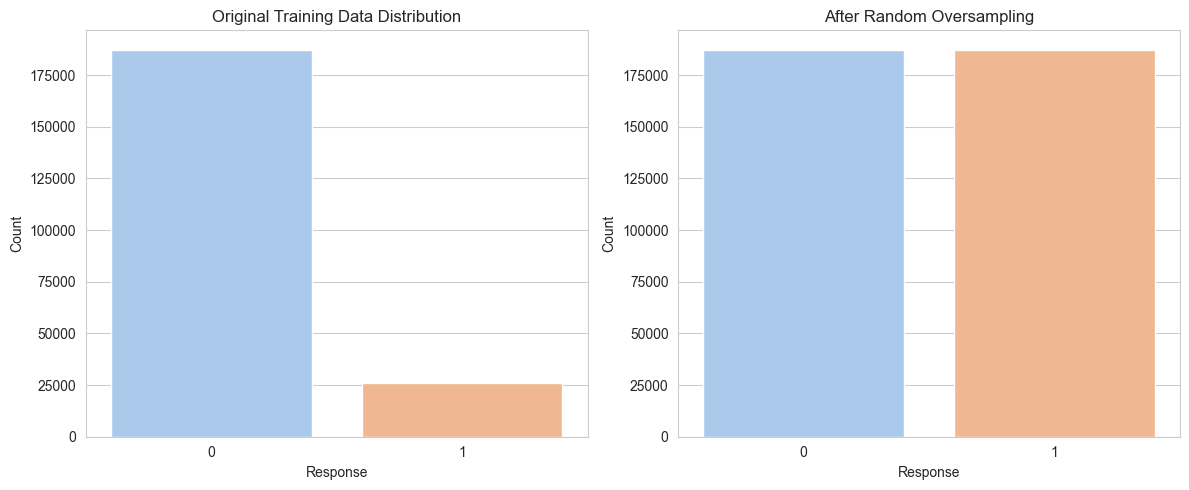

  - Best threshold found: 0.69 (F1-score: 0.4361)

--- Evaluating: Undersampling (Threshold: 0.69) ---

Summary for Undersampling:
- Overall Accuracy: 77.23%, Precision: 31.30%, Recall (TPR): 71.76%
- Disparate Impact (difference in positive rates): 8.94%
- Difference in Equal Opportunity (TPR): 3.41%
- Difference in Predictive Equality (FPR): 7.60%

  - Best threshold found: 0.70 (F1-score: 0.4366)

--- Evaluating: SMOTE (Threshold: 0.70) ---

Summary for SMOTE:
- Overall Accuracy: 78.33%, Precision: 31.94%, Recall (TPR): 67.92%
- Disparate Impact (difference in positive rates): 7.96%
- Difference in Equal Opportunity (TPR): 2.35%
- Difference in Predictive Equality (FPR): 6.72%


Section 4: Applying Iterative Reweighting for Fairness

Starting iterative reweighting process...
Iteration 1: Weight difference (L2 norm) = 13.0273
Iteration 2: Weight difference (L2 norm) = 0.3750
Iteration 3: Weight difference (L2 norm) = 0.0141
Iteration 4: Weight difference (L2 norm) = 0.0018
Iteration 

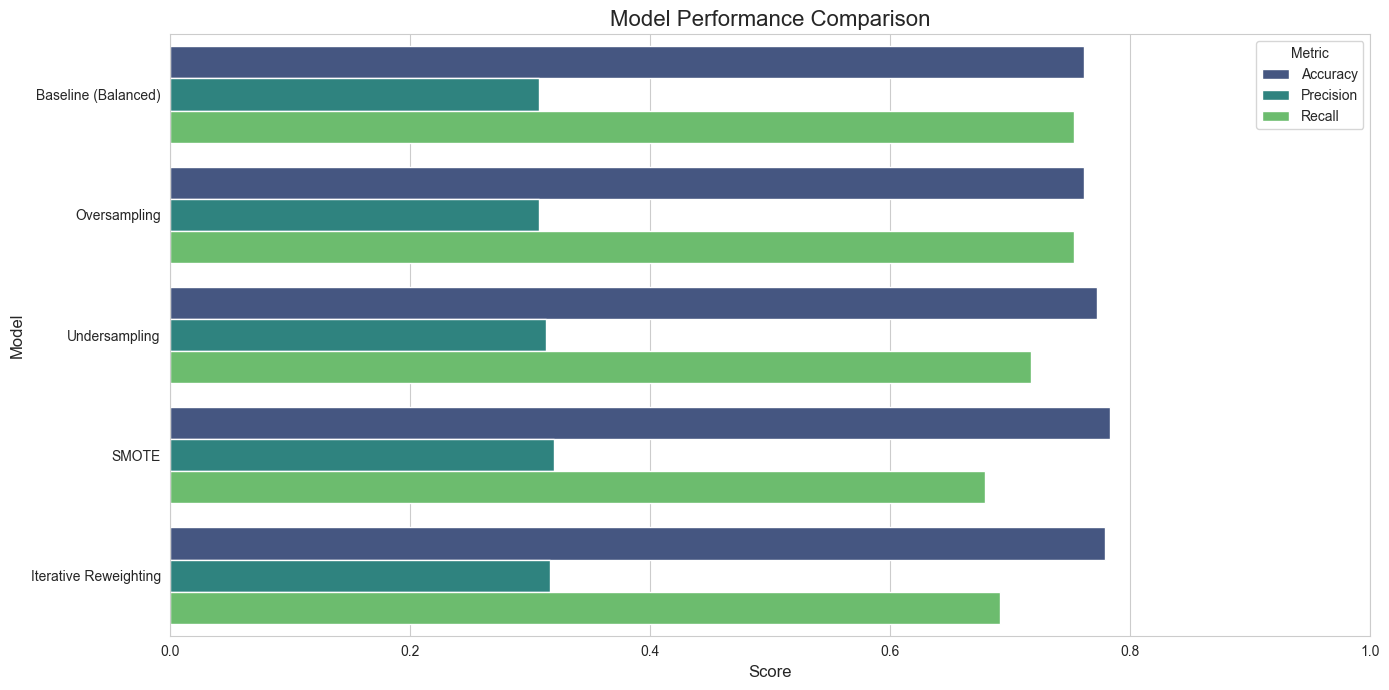

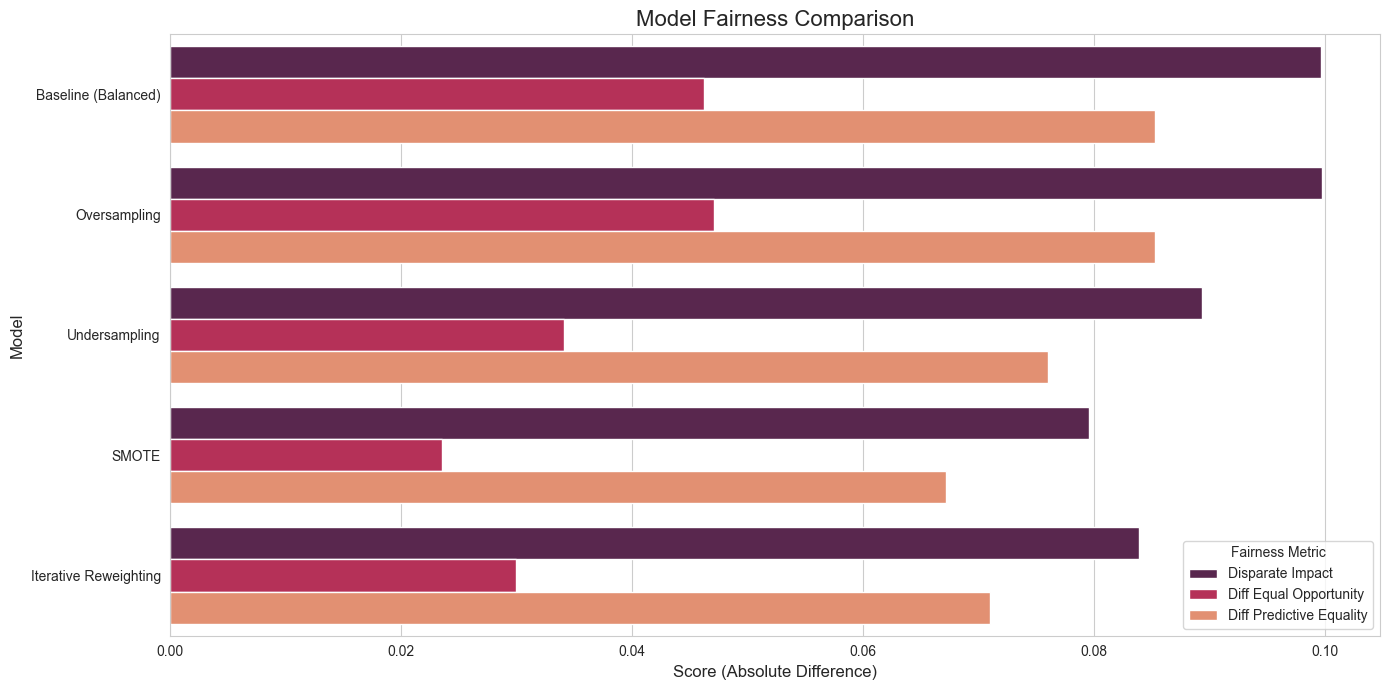

In [8]:
# -----------------------------------------------------------------------------
# health_insurance_fairness_comprehensive_final_v2.py
# -----------------------------------------------------------------------------
#
#
# Prerequisite: pip install scikit-learn pandas numpy cvxpy matplotlib seaborn
# -----------------------------------------------------------------------------

# ## 1. Data Loading and Preprocessing
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.neighbors import NearestNeighbors
import warnings
import math
import cvxpy as cp
# --- NEW: Visualization Libraries ---
import matplotlib.pyplot as plt
import seaborn as sns

warnings.filterwarnings("ignore")
sns.set_style("whitegrid")

# Load the dataset
try:
    # IMPORTANT: Update this path to your actual file location
    data = pd.read_csv(r"C:\Users\MyAccount\Downloads\archive\train.csv")
    print("Successfully loaded 'train.csv'.")
except FileNotFoundError:
    print("Error: 'train.csv' not found. Creating a dummy dataset.")
    data = pd.DataFrame({
        'id': range(2000), 'Gender': np.random.choice(['Male', 'Female'], 2000),
        'Age': np.random.randint(20, 80, 2000), 'Driving_License': np.random.randint(0, 2, 2000),
        'Previously_Insured': np.random.randint(0, 2, 2000), 'Vehicle_Age': np.random.choice(['< 1 Year', '> 2 Years'], 2000),
        'Vehicle_Damage': np.random.choice(['Yes', 'No'], 2000), 'Annual_Premium': np.random.uniform(2000, 50000, 2000),
        'Vintage': np.random.randint(10, 300, 2000), 'Response': np.random.choice([0, 1], 2000, p=[0.88, 0.12])
    })

# --- Preprocessing ---
data = data.drop('id', axis=1)
data = data[data['Gender'].isin(['Male', 'Female'])]
data_preprocessed = pd.get_dummies(data, columns=data.select_dtypes(include=['object', 'category']).columns, drop_first=True)

# --- FIX for SMOTE TypeError ---
for col in data_preprocessed.select_dtypes(include='bool').columns:
    data_preprocessed[col] = data_preprocessed[col].astype(int)
# -----------------------------

SENSITIVE_ATTR = 'Gender_Male'
TARGET = 'Response'
if SENSITIVE_ATTR not in data_preprocessed.columns: data_preprocessed[SENSITIVE_ATTR] = 0
data_preprocessed[SENSITIVE_ATTR] = data_preprocessed[SENSITIVE_ATTR].astype(int)

# ## 1.5. Exploratory Data Analysis (EDA)
print("\n--- Section 1.5: Exploratory Data Analysis ---")
plt.figure(figsize=(18, 5))

# Plot 1: Target variable distribution (Class Imbalance)
plt.subplot(1, 3, 1)
sns.countplot(x=TARGET, data=data, palette='viridis')
plt.title('Target Variable Distribution (Response)')
plt.xlabel('Customer Interested (1) vs. Not Interested (0)')
plt.ylabel('Count')

# Plot 2: Sensitive attribute distribution
plt.subplot(1, 3, 2)
sns.countplot(x='Gender', data=data, palette='plasma')
plt.title('Sensitive Attribute Distribution (Gender)')
plt.xlabel('Gender')
plt.ylabel('Count')

# Plot 3: Target distribution by sensitive attribute
plt.subplot(1, 3, 3)
sns.countplot(x='Gender', hue=TARGET, data=data, palette='magma')
plt.title('Response Distribution by Gender')
plt.xlabel('Gender')
plt.ylabel('Count')
plt.legend(title='Response', labels=['Not Interested', 'Interested'])

plt.tight_layout()
plt.show()

# --- Preprocessing Continuation ---
scaler = StandardScaler()
normalize_columns = ['Age', 'Annual_Premium', 'Vintage']
data_preprocessed[normalize_columns] = scaler.fit_transform(data_preprocessed[normalize_columns])

# --- Robust Data Splitting ---
X = data_preprocessed.drop(columns=TARGET)
y = data_preprocessed[TARGET]
X_main, X_test, y_main, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_train, X_val, y_train, y_val = train_test_split(X_main, y_main, test_size=0.2, random_state=42, stratify=y_main)

x_train_sensitive = X_train[SENSITIVE_ATTR]
x_test_sensitive = X_test[SENSITIVE_ATTR]
train_x = X_train.drop(columns=[SENSITIVE_ATTR])
val_x = X_val.drop(columns=[SENSITIVE_ATTR])
test_x = X_test.drop(columns=[SENSITIVE_ATTR])

male_test_mask = (x_test_sensitive == 1)
female_test_mask = (x_test_sensitive == 0)
male_test_x = test_x[male_test_mask]
male_test_y = y_test[male_test_mask]
female_test_x = test_x[female_test_mask]
female_test_y = y_test[female_test_mask]

print("\nData preprocessing and splitting complete.")

# ## Utility Functions
all_model_results = [] # --- NEW: List to store results for final comparison

def model_eval(actual, pred):
    confusion = pd.crosstab(actual, pred, rownames=['Actual'], colnames=['Predicted'])
    TP = confusion.loc[1,1] if (1 in confusion.index and 1 in confusion.columns) else 0
    TN = confusion.loc[0,0] if (0 in confusion.index and 0 in confusion.columns) else 0
    FP = confusion.loc[0,1] if (0 in confusion.index and 1 in confusion.columns) else 0
    FN = confusion.loc[1,0] if (1 in confusion.index and 0 in confusion.columns) else 0
    total = TP + TN + FP + FN
    if total == 0: return {k: 0 for k in ['ALL', 'DP', 'TPR', 'TNR', 'FPR', 'FNR', 'ACR', 'PPV']}
    out = {'ALL': total, 'DP': (TP+FP)/total, 'TPR': TP/(TP+FN) if (TP+FN) > 0 else 0,
           'TNR': TN/(FP+TN) if (FP+TN) > 0 else 0, 'FPR': FP/(FP+TN) if (FP+TN) > 0 else 0,
           'FNR': FN/(TP+FN) if (TP+FN) > 0 else 0, 'ACR': (TP+TN)/total,
           'PPV': TP/(TP+FP) if (TP+FP) > 0 else 0} # PPV = Precision
    return out

def find_best_threshold(model, x_val, y_val):
    y_pred_proba = model.predict_proba(x_val)[:, 1]
    best_threshold = 0.5; best_f1 = 0
    thresholds = np.arange(0.1, 0.9, 0.01)
    f1_scores = []
    for threshold in thresholds:
        y_pred_tuned = (y_pred_proba > threshold).astype(int)
        f1 = f1_score(y_val, y_pred_tuned)
        f1_scores.append(f1)
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = threshold
    print(f"  - Best threshold found: {best_threshold:.2f} (F1-score: {best_f1:.4f})")
    return best_threshold, thresholds, f1_scores

def evaluate_and_print_results(model, model_name, threshold):
    print(f"\n--- Evaluating: {model_name} (Threshold: {threshold:.2f}) ---")
    y_pred_proba_test = model.predict_proba(test_x)[:, 1]
    y_pred_final = (y_pred_proba_test > threshold).astype(int)
    metrics_all = model_eval(y_test, y_pred_final)

    y_pred_proba_male = model.predict_proba(male_test_x)[:, 1]
    pred_male = (y_pred_proba_male > threshold).astype(int)
    metrics_male = model_eval(male_test_y, pred_male)

    y_pred_proba_female = model.predict_proba(female_test_x)[:, 1]
    pred_female = (y_pred_proba_female > threshold).astype(int)
    metrics_female = model_eval(female_test_y, pred_female)

    di = round(abs(metrics_female['DP'] - metrics_male['DP']), 4)
    deo = round(abs(metrics_female['TPR'] - metrics_male['TPR']), 4)
    dpe = round(abs(metrics_female['FPR'] - metrics_male['FPR']), 4)
    acr = round(metrics_all['ACR'], 4)

    print(f"""
Summary for {model_name}:
- Overall Accuracy: {acr:.2%}, Precision: {metrics_all['PPV']:.2%}, Recall (TPR): {metrics_all['TPR']:.2%}
- Disparate Impact (difference in positive rates): {di:.2%}
- Difference in Equal Opportunity (TPR): {deo:.2%}
- Difference in Predictive Equality (FPR): {dpe:.2%}
""")
    # --- NEW: Store results for final plotting ---
    results = {
        'Model': model_name,
        'Accuracy': acr,
        'Precision': metrics_all['PPV'],
        'Recall': metrics_all['TPR'],
        'Disparate Impact': di,
        'Diff Equal Opportunity': deo,
        'Diff Predictive Equality': dpe
    }
    all_model_results.append(results)


# ## 2. Baseline Model with Class Weight
print("\n" + "="*50)
print("Section 2: Training Baseline Model")
print("="*50)
log_reg_base = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
log_reg_base.fit(train_x, y_train)
best_thresh_base, thresholds, f1_scores = find_best_threshold(log_reg_base, val_x, y_val)

# --- NEW: Visualization of Threshold Tuning ---
print("\n--- Visualizing Threshold Tuning for Baseline Model ---")
plt.figure(figsize=(10, 6))
plt.plot(thresholds, f1_scores, label='F1-score', color='blue')
plt.axvline(x=best_thresh_base, color='red', linestyle='--', label=f'Best Threshold = {best_thresh_base:.2f}')
plt.title('F1-Score vs. Prediction Threshold')
plt.xlabel('Threshold')
plt.ylabel('F1-Score on Validation Set')
plt.legend()
plt.grid(True)
plt.show()
# ---------------------------------------------

evaluate_and_print_results(log_reg_base, "Baseline (Balanced)", best_thresh_base)

# ## 3. Manual Resampling Techniques
print("\n" + "="*50)
print("Section 3: Applying Manual Resampling Techniques")
print("="*50)

def manual_oversample(X, y):
    df = pd.concat([X, y], axis=1)
    majority_class_count = df[y.name].value_counts().max()
    df_majority = df[df[y.name] == df[y.name].mode()[0]]
    df_minority = df[df[y.name] != df[y.name].mode()[0]]
    df_minority_oversampled = df_minority.sample(n=majority_class_count, replace=True, random_state=42)
    df_resampled = pd.concat([df_majority, df_minority_oversampled])
    return df_resampled.drop(y.name, axis=1), df_resampled[y.name]

def manual_undersample(X, y):
    df = pd.concat([X, y], axis=1)
    minority_class_count = df[y.name].value_counts().min()
    df_majority = df[df[y.name] == df[y.name].mode()[0]]
    df_minority = df[df[y.name] != df[y.name].mode()[0]]
    df_majority_undersampled = df_majority.sample(n=minority_class_count, random_state=42)
    df_resampled = pd.concat([df_majority_undersampled, df_minority])
    return df_resampled.drop(y.name, axis=1), df_resampled[y.name]

def manual_smote(X, y, k_neighbors=5):
    df = pd.concat([X, y.rename('TARGET')], axis=1)
    minority_class = y.value_counts().idxmin()
    majority_count = y.value_counts().max()
    minority_count = y.value_counts().min()
    samples_to_generate = majority_count - minority_count
    if samples_to_generate <= 0: return X, y
    minority_samples = df[df['TARGET'] == minority_class].drop('TARGET', axis=1)
    if len(minority_samples) < k_neighbors + 1: k_neighbors = len(minority_samples) - 1
    if k_neighbors == 0: return manual_oversample(X, y)
    nbrs = NearestNeighbors(n_neighbors=k_neighbors + 1).fit(minority_samples)
    indices = nbrs.kneighbors(minority_samples)[1][:, 1:]
    new_samples = []
    for _ in range(samples_to_generate):
        random_idx = np.random.choice(len(minority_samples))
        sample = minority_samples.iloc[random_idx]
        neighbor_idx = np.random.choice(indices[random_idx])
        neighbor = minority_samples.iloc[neighbor_idx]
        new_sample = sample + np.random.rand() * (neighbor - sample)
        new_samples.append(new_sample)
    new_samples_df = pd.DataFrame(new_samples, columns=X.columns)
    X_resampled = pd.concat([X, new_samples_df], ignore_index=True)
    y_resampled = pd.concat([y, pd.Series([minority_class] * len(new_samples_df))], ignore_index=True)
    return X_resampled, y_resampled

# --- 3a. Random Oversampling ---
train_x_ros, train_y_ros = manual_oversample(train_x, y_train)
log_reg_ros = LogisticRegression(solver='liblinear', random_state=42)
log_reg_ros.fit(train_x_ros, train_y_ros)
best_thresh_ros, _, _ = find_best_threshold(log_reg_ros, val_x, y_val)
evaluate_and_print_results(log_reg_ros, "Oversampling", best_thresh_ros)

# --- NEW: 3b. Visualizing Resampling Effect ---
print("\n--- Visualizing the Effect of Oversampling on Training Data ---")
fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.countplot(x=y_train, ax=axes[0], palette='pastel').set_title('Original Training Data Distribution')
axes[0].set_xlabel('Response')
axes[0].set_ylabel('Count')
sns.countplot(x=train_y_ros, ax=axes[1], palette='pastel').set_title('After Random Oversampling')
axes[1].set_xlabel('Response')
axes[1].set_ylabel('Count')
plt.tight_layout()
plt.show()

# --- 3c. Random Undersampling ---
train_x_rus, train_y_rus = manual_undersample(train_x, y_train)
log_reg_rus = LogisticRegression(solver='liblinear', random_state=42)
log_reg_rus.fit(train_x_rus, train_y_rus)
best_thresh_rus, _, _ = find_best_threshold(log_reg_rus, val_x, y_val)
evaluate_and_print_results(log_reg_rus, "Undersampling", best_thresh_rus)

# --- 3d. SMOTE ---
train_x_smote, train_y_smote = manual_smote(train_x, y_train)
log_reg_smote = LogisticRegression(solver='liblinear', random_state=42)
log_reg_smote.fit(train_x_smote, train_y_smote)
best_thresh_smote, _, _ = find_best_threshold(log_reg_smote, val_x, y_val)
evaluate_and_print_results(log_reg_smote, "SMOTE", best_thresh_smote)


# ## 4. Fair Model: Iterative Reweighting Algorithm
print("\n" + "="*50)
print("Section 4: Applying Iterative Reweighting for Fairness")
print("="*50)

def optim(loss, a, c):
    if len(loss) == 0: return np.array([])
    x = cp.Variable(loss.shape[0])
    objective = cp.Maximize(-a*cp.sum_squares(x) + cp.sum(cp.multiply(loss, x)))
    constraints = [0 <= x, cp.sum(x) == c]
    prob = cp.Problem(objective, constraints)
    try:
        prob.solve(solver=cp.SCS)
        x_val = x.value if x.value is not None else np.ones(loss.shape[0]) * (c / loss.shape[0])
        x_val[np.abs(x_val) < 0.01] = 0; x_val[x_val < 0] = 0
        return x_val
    except (cp.error.SolverError, TypeError): return np.ones(loss.shape[0]) * (c / loss.shape[0])

def dif(a, b): return np.linalg.norm(a - b)

x_train_with_meta = train_x.copy()
x_train_with_meta[SENSITIVE_ATTR] = x_train_sensitive.values
x_train_with_meta[TARGET] = y_train.values

subgroups = { "male_pos": x_train_with_meta[(x_train_with_meta[SENSITIVE_ATTR] == 1) & (x_train_with_meta[TARGET] == 1)],
              "male_neg": x_train_with_meta[(x_train_with_meta[SENSITIVE_ATTR] == 1) & (x_train_with_meta[TARGET] == 0)],
              "female_pos": x_train_with_meta[(x_train_with_meta[SENSITIVE_ATTR] == 0) & (x_train_with_meta[TARGET] == 1)],
              "female_neg": x_train_with_meta[(x_train_with_meta[SENSITIVE_ATTR] == 0) & (x_train_with_meta[TARGET] == 0)] }

if any(df.empty for df in subgroups.values()):
    print("\nWarning: One of the fairness subgroups is empty. The reweighting algorithm cannot run.")
else:
    subgroups_x = [df.drop([TARGET, SENSITIVE_ATTR], axis=1) for df in subgroups.values()]
    ordered_train_x = pd.concat(subgroups_x, axis=0)
    ordered_train_y = pd.concat([df[TARGET] for df in subgroups.values()], axis=0)
    
    wi0 = np.ones(ordered_train_x.shape[0])
    wi1 = np.zeros(ordered_train_x.shape[0])
    fair_log_reg = LogisticRegression(solver='liblinear', random_state=42, class_weight='balanced')
    A_PARAM = 10; MAX_ITER = 10

    print("\nStarting iterative reweighting process...")
    for iter_num in range(MAX_ITER):
        if dif(wi0, wi1) < 0.001 and iter_num > 0:
            print(f"\nConvergence reached at iteration {iter_num}. Stopping.")
            break
        wi1 = wi0.copy()
        fair_log_reg.fit(ordered_train_x, ordered_train_y, sample_weight=wi0)
        losses = [ -np.log(fair_log_reg.predict_proba(subgroups_x[0])[:, 1] + 1e-100),
                   -np.log(fair_log_reg.predict_proba(subgroups_x[1])[:, 0] + 1e-100),
                   -np.log(fair_log_reg.predict_proba(subgroups_x[2])[:, 1] + 1e-100),
                   -np.log(fair_log_reg.predict_proba(subgroups_x[3])[:, 0] + 1e-100) ]
        new_weights = [optim(l, a=A_PARAM, c=len(l)) for l in losses]
        wi0 = np.concatenate(new_weights)
        print(f"Iteration {iter_num+1}: Weight difference (L2 norm) = {dif(wi0, wi1):.4f}")

    if iter_num == MAX_ITER - 1: print("\nMax iterations reached.")
    
    best_thresh_fair, _, _ = find_best_threshold(fair_log_reg, val_x, y_val)
    evaluate_and_print_results(fair_log_reg, "Iterative Reweighting", best_thresh_fair)


# ## 5. Final Model Comparison
print("\n" + "="*50)
print("Section 5: Final Model Comparison Visualization")
print("="*50)

if not all_model_results:
    print("No model results to visualize.")
else:
    results_df = pd.DataFrame(all_model_results)
    results_df_melted = results_df.melt(id_vars='Model', var_name='Metric', value_name='Score')

    # Separate plots for performance and fairness metrics
    performance_metrics = ['Accuracy', 'Precision', 'Recall']
    fairness_metrics = ['Disparate Impact', 'Diff Equal Opportunity', 'Diff Predictive Equality']

    # Performance Plot
    plt.figure(figsize=(14, 7))
    sns.barplot(data=results_df_melted[results_df_melted['Metric'].isin(performance_metrics)],
                x='Score', y='Model', hue='Metric', palette='viridis')
    plt.title('Model Performance Comparison', fontsize=16)
    plt.xlabel('Score', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.xlim(0, 1)
    plt.legend(title='Metric')
    plt.tight_layout()
    plt.show()

    # Fairness Plot
    # Lower is better for these metrics
    plt.figure(figsize=(14, 7))
    sns.barplot(data=results_df_melted[results_df_melted['Metric'].isin(fairness_metrics)],
                x='Score', y='Model', hue='Metric', palette='rocket')
    plt.title('Model Fairness Comparison', fontsize=16)
    plt.xlabel('Score (Absolute Difference)', fontsize=12)
    plt.ylabel('Model', fontsize=12)
    plt.legend(title='Fairness Metric')
    plt.tight_layout()
    plt.show()